In [1]:
%matplotlib inline

In [2]:
import xray 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## Input dam info

In [3]:
Dam_info = pd.read_csv('/raid/yifan/Reservoir_modeling/Run_reservoir/reservoir_to_model_maxFlowFromRVIC_exceed0.2.csv')

In [66]:
starting_year = max(Dam_info['year_operated_start_of_Calendar_year'][4],1949)+1
end_year = 2010
starting_time = str(starting_year)+'-10-01 12:00:00' #This is the start of water year----starting_year+1
end_time = str(end_year)+'-09-30 12:00:00'
starting_date = str(starting_year)+'-10-01 00:00:00' #This is the start of water year----starting_year+1
end_date = str(end_year)+'-09-30 00:00:00'
time_index = pd.date_range(start = starting_time,end = end_time ,freq='D')

In [18]:
col_del = np.concatenate([np.arange(0,starting_year-Dam_info['year_operated_start_of_Calendar_year'][4],1),np.arange(-1,end_year-2015-1,-1)])

In [19]:
col_del

array([ 0,  1,  2,  3,  4,  5,  6, -1, -2, -3, -4, -5])

## Choose Douglas as example
## Read in TVA observed stream flow data

In [8]:
Raw = pd.ExcelFile('/raid/yifan/Reservoir_modeling/TVA_reservoir_data/douglas.xlsx')

In [37]:
Total_Q = Raw.parse(sheetname='TotalQ')
col_del = np.concatenate([np.arange(0,starting_year-Dam_info['year_operated_start_of_Calendar_year'][4],1),np.arange(-1,end_year-2015-1,-1)])
#Observed_Q = Total_Q.drop(Total_Q.columns[[0,-1]],axis=1).dropna()
Observed_Q = Total_Q.groupby(Total_Q.index.map(lambda t: t.month)).mean()
M = Observed_Q.drop(Observed_Q.columns[col_del],axis=1)
M.iloc[0:10,0]=np.nan
M.iloc[10:12,M.shape[1]-1]=np.nan

## Read in modeled streamflow data using new guide curve

In [41]:
Raw_model = xray.open_dataset('/raid/yifan/Reservoir_modeling/Run_reservoir/result_new_guide_curve.modified_flow.nc')

## Read in modeled streamflow data using old guide curve

In [42]:
Original_model = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/simple_reservoir/Tennessee/maxFlowFromRVIC_exceed0.2/Tennessee.modified_flow.nc')

## Read in naturalized flow provided by TVA

In [52]:
filename_latlon = str(Dam_info['grid_lat'][4])+'_'+str(Dam_info['grid_lon'][4])+'.daily.1903_2013'
dir_latlon = '/raid2/ymao/VIC_RBM_east_RIPS/data/TVA_data/naturalized_flow/downscaled_daily_flow/latlon/'+filename_latlon
Nflow_TVA = pd.read_csv(dir_latlon,sep=' ',header=None,parse_dates=[[0,1,2]])
Nflow_TVA.rename(columns={'0_1_2': 'Time', 3: 'flow(cfs)'}, inplace=True)
Nflow_TVA = Nflow_TVA.set_index('Time')


In [57]:
Nflow_TVA = Nflow_TVA.ix[starting_date:end_date]

In [58]:
Natual_flow_TVA = Nflow_TVA['flow(cfs)'].groupby(Nflow_TVA.index.map(lambda t: t.month)).mean()

## Read in RVIC output

In [59]:
RVIC = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RVIC/Tennessee_8th_grid/hist/Tennessee_UH_1.hist_1949_2010.calibrated_1961_1970.rvic.h0a.2011-01-01.nc')
RVIC = RVIC.isel(time=slice(0,-1))

In [60]:
RVIC_flow = RVIC.sel(lat = Dam_info['grid_lat'][4],lon = Dam_info['grid_lon'][4])

In [68]:
RVIC_flow = RVIC_flow.sel(time = time_index)

In [69]:
Q = RVIC_flow.groupby('time.month').mean('time')

In [70]:
Q.streamflow*np.power(3.28,3)

<xray.DataArray 'streamflow' (month: 12)>
array([  9506.28429891,  12630.29877262,  13806.03826498,  10649.41769692,
         6190.59729352,   4384.20049822,   3613.42249472,   3506.37552825,
         3614.7912227 ,   3653.4844413 ,   4768.59391459,   7020.15252577])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## Streamflow based by old guide curve

In [71]:
Original_streamflow = Original_model.sel(lat = Dam_info['grid_lat'][4],lon = Dam_info['grid_lon'][4])

## Streamflow based by new guide curve

In [72]:
Raw_streamflow = Raw_model.sel(lat = Dam_info['grid_lat'][4],lon = Dam_info['grid_lon'][4])

In [73]:
Model_Q = Raw_streamflow.sel(time = time_index)
Original_Q = Original_streamflow.sel(time = time_index)
L = Model_Q.groupby('time.month').mean('time')
L_original = Original_Q.groupby('time.month').mean('time')

In [76]:
water_year = '(water year:'+str(starting_year+1)+'-'+str(end_year)+')'

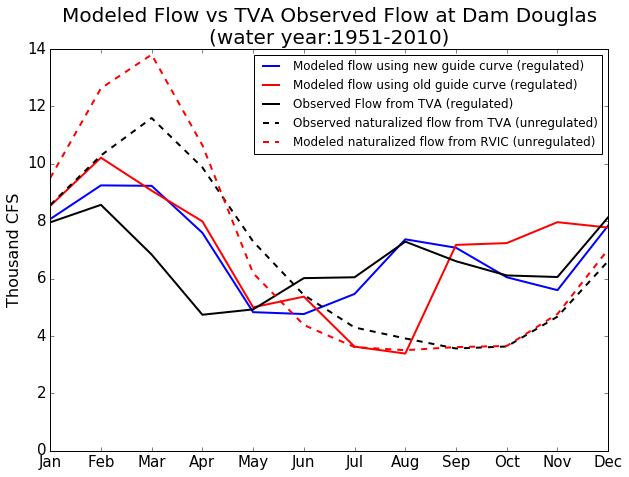

In [77]:
plt.figure(figsize=[10,7.2])
f1, = plt.plot(np.arange(1,13,1),L.streamflow/1000,'b-',label='Modeled flow using new guide curve (regulated)',linewidth=2)
f3, = plt.plot(np.arange(1,13,1),L_original.streamflow/1000,'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
f2, = plt.plot(np.arange(1,13,1),M.mean(axis=1)/1000,'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
f4, = plt.plot(np.arange(1,13,1),Natual_flow_TVA/1000,'k--',label='Observed naturalized flow from TVA (unregulated)',linewidth=2)
f5, = plt.plot(np.arange(1,13,1),Q.streamflow*np.power(3.28,3)/1000,'r--',label='Modeled naturalized flow from RVIC (unregulated)',linewidth=2)
plt.legend(handles = [f1,f3,f2,f4,f5])
plt.title('Modeled Flow vs TVA Observed Flow at Dam Douglas\n'+water_year,fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Thousand CFS',fontsize=16)
plt.xticks(np.arange(1,13,1),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlim(1,12)
plt.ylim(0,)
plt.savefig('/raid/yifan/Reservoir_modeling/Analysis/fig_comparison_modeled_observed/Dam_Douglas_modeled_flow_vs_TVA_observed_flow',dpi=300)